In [1]:
import xgboost as xgb
from xgboost import XGBClassifier

#import lightgbm as lbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
pd.set_option('display.max_columns', 500)

X_train = pd.read_csv("data/X_train.csv", index_col=0, error_bad_lines=False)
X_test = pd.read_csv("data/X_test.csv", index_col=0, error_bad_lines=False)
X_train.head(3)

b'Skipping line 2168: expected 31 fields, saw 33\nSkipping line 4822: expected 31 fields, saw 37\nSkipping line 4859: expected 31 fields, saw 37\nSkipping line 7342: expected 31 fields, saw 37\n'


,images_count,image_width,image_height,image_url,product_description,product_size,material,age,warranty,year,color,product_width,wifi,condition,product_length,shoe_size,vintage,brand,author,editor,product_height,weight,price,category,sub_category_1,sub_category_2,sub_category_3,sub_category_4,product_name,store_name
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,3458.0,2552.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Superbe petit top bustier avec explosion de co...,44,100 % polyester,NaN,NaN,NaN,Multicolore,NaN,NaN,bon état,NaN,NaN,False,NaN,NaN,NaN,NaN,200.0,4.5,mode,"tops, t-shirts, débardeurs femme",NaN,NaN,NaN,Top bustier multicolore,Emmaüs 88 Neufchateau
1,2,2486.0,2254.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,"Radio ITT Océnic Flirt, année 70\nPour déco",NaN,Plastique,NaN,NaN,NaN,Jaune,NaN,NaN,en l'état,NaN,NaN,True,ITT Océanic,NaN,NaN,NaN,1000.0,15.0,mobilier - deco,bibelots et objets déco,NaN,NaN,NaN,Radio ITT Océanic,Communauté Emmaüs Thouars (magasin Parthenay)
2,3,1536.0,1536.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Veste boléro à manches courtes NÛMPH. Gris chi...,40,"Polyester, coton, laine",NaN,NaN,NaN,Gris,NaN,NaN,neuf,NaN,NaN,False,Nûmph,NaN,NaN,NaN,360.0,16.0,label selection,mode,mode femme,NaN,NaN,NaN,Label Emmaüs Chambéry


In [3]:
y_train = pd.read_csv("data/y_train.csv", index_col=0)


### is there any shoes in test data

In [4]:
X_train.shoe_size.notnull().sum(), X_test.shoe_size.notnull().sum()

(223, 77)

### df for shoes only

In [5]:
df = pd.concat([X_train,y_train], axis=1)
df = df[df.shoe_size.notnull()]
print(df.shape)
df.head()

(223, 31)


,images_count,image_width,image_height,image_url,product_description,product_size,material,age,warranty,year,color,product_width,wifi,condition,product_length,shoe_size,vintage,brand,author,editor,product_height,weight,price,category,sub_category_1,sub_category_2,sub_category_3,sub_category_4,product_name,store_name,duration
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
25,3,2223.0,2908.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Superbe paire de chaussure de ville pour homme...,NaN,Cuir,NaN,NaN,NaN,Marron,NaN,NaN,bon état,NaN,43.0,False,DDL PER MAX,NaN,NaN,NaN,1.4,15.0,label selection,mode,mode homme,chaussures et bottes homme,NaN,"Chaussure de ville homme , cuir marron , point...",Emmaüs 88 Neufchateau,1
46,5,2448.0,2448.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Sandales compensées en cuir rouge femme MINELL...,NaN,cuir,NaN,NaN,NaN,Rouge,NaN,NaN,bon état,NaN,40.0,False,MINELLI,NaN,NaN,NaN,500.0,15.0,label selection,mode,accessoires et maroquinerie,chaussures,mode femme,Sandales compensées en cuir rouge femme MINELLI,La Boutique Emmaüs de Lorient Plénéno,0
179,6,2448.0,2448.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Baskets basses en tissu couleur sable. \n\n- F...,NaN,Non renseignée,NaN,NaN,NaN,Fauve,NaN,NaN,bon état,NaN,38.0,False,Non renseignée,NaN,NaN,NaN,500.0,8.0,mode,chaussures et bottes femme,label selection,NaN,NaN,Baskets basses en tissu couleur sable,La Boutique Emmaüs de Lorient Plénéno,1
202,6,2448.0,2448.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Bottines noires à talons aiguilles pour femme ...,NaN,non renseignée,NaN,NaN,NaN,Noir,NaN,NaN,neuf,NaN,39.0,False,CLOSER,NaN,NaN,NaN,600.0,9.0,label selection,chaussures,chaussures et bottes femme,NaN,NaN,Bottines noires à talons aiguilles pour femme ...,Emmaüs Sacré Dressing !,1
223,5,800.0,800.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Bottines en daim noir Calvin Klein. Intérieur ...,NaN,"Cuir, daim",NaN,NaN,NaN,Noir,NaN,NaN,neuf,NaN,39.0,NaN,Calvin Klein,NaN,NaN,NaN,1080.0,20.0,mode,chaussures et bottes femme,label selection,NaN,NaN,Calvin KLEIN - Bottines femme en daim noir - P...,Label Emmaüs Chambéry,2


### keep only numeric

In [6]:
df_num = df.select_dtypes(include=[np.number])
print(df_num.shape)
df_num.head()

(223, 11)


,images_count,image_width,image_height,year,product_width,product_length,shoe_size,product_height,weight,price,duration
id,,,,,,,,,,,
25,3,2223.0,2908.0,NaN,NaN,NaN,43.0,NaN,1.4,15.0,1
46,5,2448.0,2448.0,NaN,NaN,NaN,40.0,NaN,500.0,15.0,0
179,6,2448.0,2448.0,NaN,NaN,NaN,38.0,NaN,500.0,8.0,1
202,6,2448.0,2448.0,NaN,NaN,NaN,39.0,NaN,600.0,9.0,1
223,5,800.0,800.0,NaN,NaN,NaN,39.0,NaN,1080.0,20.0,2


### Modelisation

In [7]:
y_train_num = df_num['duration']
X_train_num = df_num.drop(['duration'], axis=1)

In [8]:
clf = XGBClassifier(n_estimators = 10, 
                       learning_rate = 0.05,
                       max_depth=6,
                       n_jobs=1,
                       alpha = 0.1)

In [9]:
clf.fit(X_train_num, y_train_num, 
        verbose=False,
        early_stopping_rounds=10, 
        eval_metric="mlogloss",
        eval_set=[(X_train_num, y_train_num)]
        )

XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Evaluation

In [10]:
print(clf.best_score)
clf.evals_result_


0.870668


{'validation_0': {'mlogloss': [1.069335,
   1.041612,
   1.01569,
   0.991274,
   0.967707,
   0.945665,
   0.925241,
   0.906267,
   0.888635,
   0.870668]}}

|eval|cv|submission|
|---|---|---|
|xgb + only num|0.870668|?|

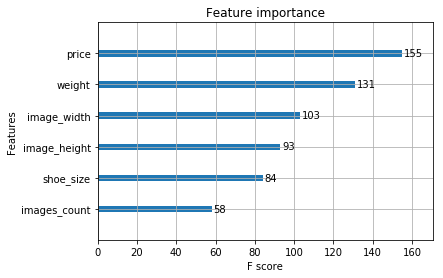

In [11]:
xgb.plot_importance(clf)
# xgb.plot_tree(bst, num_trees=2)
# xgb.to_graphviz(bst, num_trees=2)

### save model

In [12]:
clf.save_model('shoes_model')

### submission 

In [18]:
print(X_test.shape)
X_test = X_test._get_numeric_data()
predicted_test_tr = clf.predict_proba(X_test)
print(predicted_test_tr.shape)
predicted_test_tr


(2960, 10)
(2960, 3)


array([[0.23505665, 0.38705906, 0.37788427],
       [0.29320115, 0.42915118, 0.27764767],
       [0.28179857, 0.44130304, 0.27689832],
       ...,
       [0.2966351 , 0.3855874 , 0.31777748],
       [0.34754327, 0.31856045, 0.33389625],
       [0.29424137, 0.30115506, 0.40460354]], dtype=float32)

In [14]:
pred_test = predicted_test_tr
df_submission = pd.DataFrame(pred_test, index=X_test.index)

In [15]:
df_submission.head()

,0,1,2
id,,,
0,0.235057,0.387059,0.377884
1,0.293201,0.429151,0.277648
2,0.281799,0.441303,0.276898
3,0.380078,0.355392,0.264530
4,0.286995,0.347424,0.365580


In [16]:
import io, math, requests

# Only works in Python3, see comment below for Python2
def submit_prediction(df, sep=',', **kwargs):
    # TOKEN to recover on the platform: "Submissions"> "Submit from your Python Notebook"
    TOKEN=''  
    URL='https://qscore.datascience-olympics.com/api/submissions'
    #buffer = io.BytesIO() # Python 2
    buffer = io.StringIO() # Python 3
    df.to_csv(buffer, sep=sep, **kwargs)
    buffer.seek(0)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)},files={'datafile': buffer})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} seconds.'.format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0))))
    if r.status_code != 200:
        raise Exception(r.text)



In [17]:
#submit_prediction(df_submission, sep=',', index=True)